In [1]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import scipy
import wget
from math import ceil

In [2]:
#filename = wget.download("https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat")
data = scipy.io.loadmat("burgers_data_R10.mat")

In [3]:
a, u = data["a"], data["u"]

In [4]:
a.shape, u.shape

((2048, 8192), (2048, 8192))

In [5]:
a = torch.tensor(a[:, torch.newaxis, :], dtype=torch.float32)
u = torch.tensor(u[:, torch.newaxis, :], dtype=torch.float32)

In [6]:
a.shape, u.shape

(torch.Size([2048, 1, 8192]), torch.Size([2048, 1, 8192]))

In [7]:
mesh = torch.linspace(0, 2 * torch.pi, u.shape[-1])

In [8]:
a[0,0].shape, u[0,0].shape

(torch.Size([8192]), torch.Size([8192]))

In [9]:
a.shape

torch.Size([2048, 1, 8192])

In [10]:
a_with_mesh = torch.cat((a, mesh[torch.newaxis, torch.newaxis, :].repeat(u.shape[0], 1, 1)), axis=1)
# a_with_mesh is a with the mesh from [0, 2*pi] as extra channel and is used as input

In [11]:
a_with_mesh.shape

torch.Size([2048, 2, 8192])

In [12]:
train_x, test_x = a_with_mesh[:1000], a_with_mesh[1000:1200]
train_y, test_y = u[:1000], u[1000:1200]

In [13]:
train_x.shape, train_y.shape

(torch.Size([1000, 2, 8192]), torch.Size([1000, 1, 8192]))

In [81]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        
        scale = 1.0 / (in_channels * out_channels)
        
        self.weights = nn.Parameter(scale * torch.rand(in_channels, out_channels, modes, dtype=torch.cfloat))
        
        
    def complex_mult1d(self, x_hat, w):
        return torch.einsum("biM,ioM->boM", x_hat, w)
    
    def forward(self, x):
        batch, channels, spatial_points = x.shape
        # shape of x_hat is (batch, in_channels, spatial_points//2+1)
        x_hat = torch.fft.rfft(x)
        
        # shape of x_hat_under_modes is (batch, in_channels, self.modes)
        x_hat_under_modes = x_hat[..., :self.modes]
        
        # shape of out_hat_under_modes is (batch, out_channels, self.modes)
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, self.weights)

        # shape of out_hat is (batch, out_channels, spatial_points//2+1)
        out_hat = torch.zeros(batch, self.out_channels, x_hat.shape[-1], dtype=torch.cfloat)
        out_hat[..., :self.modes] = out_hat_under_modes

        out = torch.fft.irfft(out_hat, n=spatial_points)

        return out

In [82]:
class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super().__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = nn.functional.gelu(x)
        x = self.mlp2(x)
        return x

In [83]:
class FNOBlock1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes, width, activation):
        super().__init__()
        self.spectral_conv = SpectralConv1d(in_channels, out_channels, modes)
        self.bypass_conv = nn.Conv1d(in_channels, out_channels, 1)
        self.mlp = MLP(width, width, width)
        self.activation = activation

    def forward(self, x):
        return self.activation(self.mlp(self.spectral_conv(x)) + self.bypass_conv(x))

In [84]:
class FNO1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes, width, activation, n_blocks = 4):
        super().__init__()
        
        self.lifting = nn.Conv1d(in_channels, width, 1)

        self.fno_blocks = []
        for i in range(n_blocks):
            self.fno_blocks.append(FNOBlock1d(width, width, modes, width, activation))

        self.projection = MLP(width, out_channels, 2*width)

    def forward(self, x):
        x = self.lifting(x)

        for fno_block in self.fno_blocks:
            x = fno_block(x)

        x = self.projection(x)

        return x

In [18]:
def dataloader(dataset_x, dataset_y, batch_size):
    n_samples = dataset_x.shape[0]

    n_batches = int(ceil(n_samples / batch_size))

    permutation = torch.randperm(n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

In [85]:
fno = FNO1d(2, 1, 16, 64, nn.functional.gelu, 4)

In [86]:
loss_hist = []
val_loss_hist = []

In [87]:
criterion = nn.MSELoss()
optimizer = optim.Adam(fno.parameters(), lr=3e-4)
epochs = 200

# Training loop
for epoch in range(1,epochs+1):
    for (batch_x, batch_y) in dataloader(train_x[..., ::32], train_y[..., ::32], batch_size=100):
        # Forward pass
        outputs = fno(batch_x)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.8f}')
        loss_hist.append(loss.item())
        val_loss_hist.append(criterion(fno(test_x[..., ::32]), test_y[..., ::32]).item())

Epoch [1/200], Loss: 0.27083528
Epoch [10/200], Loss: 0.22083589
Epoch [20/200], Loss: 0.16271394
Epoch [30/200], Loss: 0.06706347
Epoch [40/200], Loss: 0.05393590
Epoch [50/200], Loss: 0.05526026
Epoch [60/200], Loss: 0.05930272
Epoch [70/200], Loss: 0.05609487
Epoch [80/200], Loss: 0.04934766
Epoch [90/200], Loss: 0.05874984
Epoch [100/200], Loss: 0.04587204
Epoch [110/200], Loss: 0.04212299
Epoch [120/200], Loss: 0.05800579
Epoch [130/200], Loss: 0.05691409
Epoch [140/200], Loss: 0.05345018
Epoch [150/200], Loss: 0.04849006
Epoch [160/200], Loss: 0.04697486
Epoch [170/200], Loss: 0.03652807
Epoch [180/200], Loss: 0.05638298
Epoch [190/200], Loss: 0.04660289
Epoch [200/200], Loss: 0.05106673


In [88]:
with torch.no_grad():
    test_outputs = fno(test_x)
    test_loss = criterion(test_outputs, test_y)
    print(f'Test Loss: {test_loss.item():.8f}')

Test Loss: 0.05623205


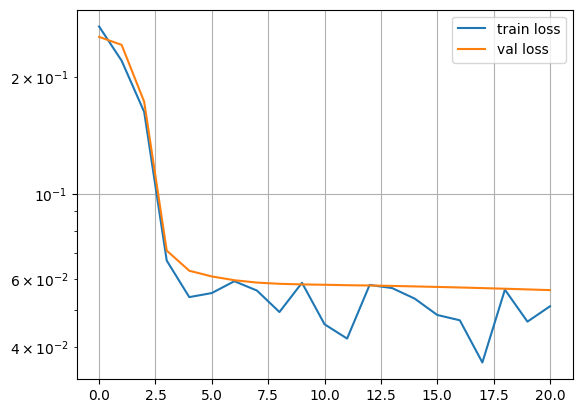

In [89]:
plt.plot(loss_hist, label="train loss")
plt.plot(val_loss_hist, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

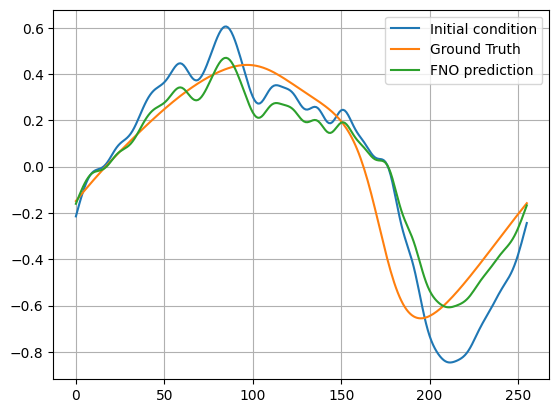

In [90]:
plt.plot(test_x[1, 0, ::32], label="Initial condition")
plt.plot(test_y[1, 0, ::32], label="Ground Truth")
plt.plot(fno(test_x[1:2, :, ::32])[0,0].detach().numpy(), label="FNO prediction")
plt.legend()
plt.grid()